In [377]:
#!pip install rapidfuzz # Нужно для Colab

import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from rapidfuzz import fuzz, process
from datetime import datetime
from functools import lru_cache
import requests
import os
from folium.features import CustomIcon
from folium.plugins import GroupedLayerControl
from matplotlib.patches import Wedge
import numpy as np
from PIL import Image

# Словарь для хранения важных рабочих английских названий столбцов
column_names = {
    "region": "region",
    "year": "year",
    "total_population": "total_population"
}


In [378]:

# Функция для загрузки файлов
def load_data_files():
    default_geojson_path = 'Voronezh_region.geojson'
    default_csv_path = 'combined_table.csv'
    custom_folder = 'custom_files'
    default_geojson_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/json/Voronezh_region.geojson'
    default_csv_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/combined_table.csv'

    if not os.path.exists(custom_folder):
        os.makedirs(custom_folder)

    final_geojson_path = default_geojson_path
    final_csv_path = default_csv_path

    def download_from_url(file_path, url):
        if not os.path.exists(file_path):
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"Файл {file_path} успешно загружен с {url}")
            else:
                print(f"Ошибка при загрузке {file_path}: HTTP {response.status_code}")
        else:
            print(f"Файл {file_path} уже существует.")

    source_choice = input("Хотите загрузить данные с GitHub (1) или использовать локальные файлы (2)? Вы также можете оставить поле пустым и будут использованы стандартные файлы. Введите 1 или 2: ").strip()
    if source_choice == '1':
        github_choice = input("Использовать стандартные ссылки GitHub (1) или ввести свои URL (2)? Введите 1 или 2: ").strip()
        if github_choice == '1':
            download_from_url(default_geojson_path, default_geojson_url)
            download_from_url(default_csv_path, default_csv_url)
            return default_geojson_path, default_csv_path
        elif github_choice == '2':
            print('Оставьте поле пустым, если не хотите загружать новый файл.')
            geojson_url = input("Введите URL для GeoJSON файла с GitHub: ").strip()
            csv_url = input("Введите URL для CSV файла с GitHub: ").strip()
            if geojson_url:
                custom_geojson_path = os.path.join(custom_folder, 'custom_Voronezh_region.geojson')
                download_from_url(custom_geojson_path, geojson_url)
                final_geojson_path = custom_geojson_path
            else:
                if not os.path.exists(default_geojson_path):
                    download_from_url(default_geojson_path, default_geojson_url)
            if csv_url:
                custom_csv_path = os.path.join(custom_folder, 'custom_combined_table.csv')
                download_from_url(custom_csv_path, csv_url)
                final_csv_path = custom_csv_path
            else:
                if not os.path.exists(default_csv_path):
                    download_from_url(default_csv_path, default_csv_url)
            return final_geojson_path, final_csv_path
        else:
            print("Используются стандартные файлы.")
            if not os.path.exists(default_geojson_path):
                download_from_url(default_geojson_path, default_geojson_url)
            if not os.path.exists(default_csv_path):
                download_from_url(default_csv_path, default_csv_url)
            return default_geojson_path, default_csv_path
    elif source_choice == '2':
        geojson_input = input(f"Введите путь к GeoJSON (или пусто для '{default_geojson_path}'): ").strip()
        csv_input = input(f"Введите путь к CSV (или пусто для '{default_csv_path}'): ").strip()
        final_geojson_path = geojson_input if geojson_input else default_geojson_path
        final_csv_path = csv_input if csv_input else default_csv_path
        if not os.path.exists(final_geojson_path):
            print(f"Файл {final_geojson_path} не найден.")
        if not os.path.exists(final_csv_path):
            print(f"Файл {final_csv_path} не найден.")
        return final_geojson_path, final_csv_path
    else:
        print("Используются стандартные файлы.")
        if not os.path.exists(default_geojson_path):
            download_from_url(default_geojson_path, default_geojson_url)
        if not os.path.exists(default_csv_path):
            download_from_url(default_csv_path, default_csv_url)
        return default_geojson_path, default_csv_path

# Загружаем файлы
geojson_path, csv_path = load_data_files()

# Чтение CSV
combined_data_df = pd.read_csv(csv_path, sep=None, encoding='utf-8-sig', header=[0, 1])
english_headers = combined_data_df.columns.get_level_values(0).str.lower()
russian_headers = combined_data_df.columns.get_level_values(1)
header_mapping = dict(zip(english_headers, russian_headers))
combined_data_df.columns = english_headers
combined_data_df[column_names["region"]] = combined_data_df[column_names["region"]].str.strip().str.lower().str.replace('ё', 'е')
available_data = [col for col in combined_data_df.columns if col not in [column_names["region"], column_names["year"]]]

# Чтение GeoJSON
with open(geojson_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)


Оставьте поле пустым, если не хотите загружать новый файл.
Файл custom_files\custom_Voronezh_region.geojson уже существует.
Файл custom_files\custom_combined_table.csv уже существует.


C:\Users\user\AppData\Local\Temp\ipykernel_6176\1888668043.py:82: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  combined_data_df = pd.read_csv(csv_path, sep=None, encoding='utf-8-sig', header=[0, 1])


ParserError: Header rows must have an equal number of columns.

In [ ]:

# Создание карты
region_center_incsv = [51.67, 39.18]
m = folium.Map(location=region_center_incsv, zoom_start=8)

# Функции обработки данных
def get_russian_name(english_name):
    return header_mapping.get(english_name, english_name)

def group_columns_by_year(df, region_name):
    region_data = df[df[column_names["region"]] == region_name]
    grouped_data = {}
    data_columns = [col for col in df.columns if col not in [column_names["region"], column_names["year"]]]
    for col in data_columns:
        grouped_data[col] = {}
        for _, row in region_data.iterrows():
            year = str(row[column_names["year"]])  # Явно приводим год к строке
            value = row[col]
            grouped_data[col][year] = value
    return grouped_data

def get_closest_year_value(grouped_data, column, current_year):
    if column not in grouped_data or not grouped_data[column]:
        return None
    years = list(grouped_data[column].keys())
    values = list(grouped_data[column].values())
    if not years:
        return None
    closest_year = min(years, key=lambda y: abs(int(y) - current_year))
    return float(values[years.index(closest_year)])

def find_matching_region(target, candidates):
    target_normalized = target.strip().lower().replace('ё', 'е')
    if target_normalized in candidates:
        return target_normalized
    match = process.extractOne(target_normalized, candidates, scorer=fuzz.token_set_ratio, score_cutoff=85)
    if match:
        best_match = match[0]
        if any(best_match != candidate and best_match in candidate for candidate in candidates):
            return None
        return best_match
    return None


In [ ]:

def create_chart(region_name, grouped_data, column):
    group_name = get_russian_name(column)
    if group_name == column:
        print(f"Предупреждение: Русское название не найдено для '{column}'.")
    if column not in grouped_data or not grouped_data[column]:
        return None
    years = [int(year) for year in grouped_data[column].keys()]
    values = [float(value) for value in grouped_data[column].values()]
    if not years or not values:
        return None
    plt.figure(figsize=(3, 2))
    bars = plt.bar(years, values, color=['blue', 'green', 'red'], alpha=0.6, label=group_name)
    plt.plot(years, values, color='black', marker='o', linewidth=2, label='Тренд')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', fontsize=8)
    plt.title(f'{group_name}\n{region_name}', fontsize=10)
    plt.xlabel('Год', fontsize=8)
    plt.ylabel(group_name, fontsize=8)
    plt.xticks(years, fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()
    return f'<img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">'

# Функция стиля для GeoJSON
def style_function(feature):
    district_name = feature['properties']['district'].lower().replace('ё', 'е')
    match, population, chart_html = process_district_data(district_name)
    if match:
        popup_html = create_popup_html(district_name.capitalize(), chart_html)
        feature['properties']['popup_html'] = popup_html
        if population:
            feature['properties']['population'] = int(population)
            if population < 35000:
                color = 'green'
            elif population < 500000:
                color = 'orange'
            elif population > 500000:
                color = 'red'
            else:
                color = 'grey'
        else:
            feature['properties']['population'] = "Данные отсутствуют"
            color = 'grey'
    else:
        color = 'grey'
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.4
    }

# Функция для создания единого HTML для всплывающего окна
def create_popup_html(district_name, chart_html):
    """Создаёт HTML для всплывающего окна с названием района и диаграммами."""
    html_template = f"""
    <div style="width: 100%; max-width: 800px; height: auto; margin: 0 auto; border: 1px solid #ddd; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); overflow: hidden; font-family: Arial, sans-serif;">
        <div style="padding: 15px; background-color: #f9f9f9; border-bottom: 1px solid #ddd;">
            <h3 style="margin: 0; font-size: 18px; color: #333;">Район: {district_name}</h3>
        </div>
        <div style="padding: 15px; display: flex; flex-direction: column; align-items: center; max-height: 350px; min-width: 300px; overflow-y: auto; background-color: #fff;">
            {chart_html if chart_html else "<p style='color: #888; text-align: center;'>Данные отсутствуют</p>"}
        </div>
    </div>
    """
    return html_template


In [ ]:

@lru_cache(maxsize=None)
def process_district_data(district_name):
    """Обрабатывает данные для района, возвращает совпадение, население и HTML с диаграммами."""
    match = find_matching_region(district_name, combined_data_df[column_names["region"]].unique())
    if not match:
        return None, 0, "Данные отсутствуют"
    grouped_data = group_columns_by_year(combined_data_df, match)
    charts = []
    population = 0
    for column in grouped_data:
        chart = create_chart(match, grouped_data, column)
        if chart:
            charts.append(chart)
        if column == column_names["total_population"]:
            population = get_closest_year_value(grouped_data, column, datetime.now().year) or 0
    chart_html = ' '.join(charts) if charts else "Данные отсутствуют"
    return match, population, chart_html

# Универсальная функция для получения данных о населённом пункте
def get_settlement_data(settlement, data_type):
    region_name = settlement.get('match')
    if not region_name:
        settlement_name = settlement['name'].lower().replace('ё', 'е')
        region_name = find_matching_region(settlement_name, combined_data_df[column_names["region"]].unique())
    
    if region_name:
        grouped_data = group_columns_by_year(combined_data_df, region_name)
        value = get_closest_year_value(grouped_data, data_type, datetime.now().year)
        return region_name, grouped_data, value
    return None, {}, None

In [ ]:

# Функции создания диаграмм для маркеров населённых пунктов
def create_bar_chart_icon(settlement, grouped_data, data_type):
    data_values = grouped_data.get(data_type, {})
    if not data_values:
        years = [str(datetime.now().year)]
        values = [0]
    else:
        years = sorted(data_values.keys())
        values = [float(data_values[year]) for year in years]
    
    plt.figure(figsize=(2, 1.5))
    if len(years) == 1:
        positions = [-1, 0, 1]
        bar_values = [0, values[0], 0]
        colors = ['white', 'gray' if values[0] > 0 else 'blue', 'white']
        plt.bar(positions, bar_values, width=0.4, color=colors, alpha=0.6)
        plt.xticks([0], years, fontsize=6, rotation=45)
    else:
        plt.bar(range(len(years)), values, width=0.4,
                color=['blue', 'green', 'red', 'orange', 'purple'][:len(years)], alpha=0.6)
        plt.xticks(range(len(years)), years, fontsize=6, rotation=45)
    
    plt.yticks(fontsize=6)
    plt.axis('off')
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', transparent=True)
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()
    return CustomIcon(f"data:image/png;base64,{image_base64}", icon_size=(50, 50))

def create_pie_chart_icon(settlement, grouped_data, data_type):
    data_values = grouped_data.get(data_type, {})
    if not data_values:
        years = [str(datetime.now().year)]
        values = [0]
    else:
        years = sorted(data_values.keys())
        values = [float(data_values[year]) for year in years]
    
    total = sum(values) if values else 1
    percentages = [value / total * 100 if total > 0 else 0 for value in values]
    color_list = ['blue', 'green', 'red', 'orange', 'purple']
    
    fig, ax = plt.subplots(figsize=(1, 1), dpi=100)
    fig.patch.set_alpha(0)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    start_angle = 0
    colors = ['gray'] if len(years) == 1 and values[0] > 0 else color_list[:len(years)]
    
    for i, percentage in enumerate(percentages):
        wedge = Wedge((0, 0), 1, start_angle, start_angle + percentage * 3.6,
                      facecolor=colors[i], edgecolor='black', alpha=0.5)
        ax.add_patch(wedge)
        start_angle += percentage * 3.6
    
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    img = Image.fromarray(image)
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return CustomIcon(f"data:image/png;base64,{img_base64}", icon_size=(50, 50))


In [ ]:

# Функции создания маркеров населённых пунктов
def add_bar_chart_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data, value = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue
        
        data_values = grouped_data.get(data_type, {})
        if not data_values:
            years = [str(datetime.now().year)]
            values = [0]
        else:
            years = sorted(data_values.keys())
            values = [float(data_values[year]) for year in years]
        
        total = sum(values) if values else 1
        tooltip_text = f"{settlement['name']}<br>"
        for year, val in zip(years, values):
            percentage = val / total * 100 if total > 0 else 0
            tooltip_text += f"{year}: {int(val)} ({percentage:.1f}%)<br>"
        
        icon = create_bar_chart_icon(settlement, grouped_data, data_type)
        if icon:
            popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br>"
            if value is not None:
                popup_html += f"<b>{get_russian_name(data_type)}:</b> {value}"
            folium.Marker(
                location=[settlement["lat"], settlement["lon"]],
                icon=icon,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=folium.Tooltip(tooltip_text)
            ).add_to(layer)

def add_pie_chart_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data, value = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue
        
        data_values = grouped_data.get(data_type, {})
        if not data_values:
            years = [str(datetime.now().year)]
            values = [0]
        else:
            years = sorted(data_values.keys())
            values = [float(data_values[year]) for year in years]
        
        total = sum(values) if values else 1
        tooltip_text = f"{settlement['name']}<br>"
        for year, val in zip(years, values):
            percentage = val / total * 100 if total > 0 else 0
            tooltip_text += f"{year}: {int(val)} ({percentage:.1f}%)<br>"
        
        icon = create_pie_chart_icon(settlement, grouped_data, data_type)
        if icon:
            popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br>"
            if value is not None:
                popup_html += f"<b>{get_russian_name(data_type)}:</b> {value}"
            folium.Marker(
                location=[settlement["lat"], settlement["lon"]],
                icon=icon,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=folium.Tooltip(tooltip_text)
            ).add_to(layer)

def add_standard_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data, value = get_settlement_data(settlement, data_type)
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br>"
        tooltip_text = settlement['name']
        if value is not None:
            popup_html += f"<b>{get_russian_name(data_type)}:</b> {value}"
            tooltip_text += f" ({value})"
        folium.Marker(
            location=[settlement["lat"], settlement["lon"]],
            tooltip=tooltip_text,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(layer)

def add_circle_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data, value = get_settlement_data(settlement, data_type)
        radius = 5 if value is None else min(max(value / 1000, 5), 20)
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br>"
        tooltip_text = settlement['name']
        if value is not None:
            popup_html += f"<b>{get_russian_name(data_type)}:</b> {value}"
            tooltip_text += f" ({value})"
        folium.CircleMarker(
            location=[settlement["lat"], settlement["lon"]],
            radius=radius,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=tooltip_text
        ).add_to(layer)


In [ ]:

# Функция для получения данных о населённых пунктах с OpenStreetMap
def fetch_settlements_from_overpass():
    """Запрашивает данные о населённых пунктах Воронежской области через Overpass API."""
    print("Получение данных о населённых пунктах с OpenStreetMap...")
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = """
    [out:json][timeout:25];
    area["name"="Воронежская область"]["admin_level"="4"]->.region;
    (
      node["place"](area.region);
    );
    out body;
    >;
    out skel qt;
    """
    response = requests.post(overpass_url, data=overpass_query)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Ошибка при запросе к Overpass API: {response.status_code}")
        return None

# Функция для обработки данных о населённых пунктах
def process_settlements_data(settlements_data, combined_data_df):
    """Обрабатывает данные о населённых пунктах, добавляя население из CSV."""
    settlements = []
    for element in settlements_data.get("elements", []):
        if element.get("type") == "node" and "tags" in element:
            tags = element["tags"]
            settlement_name = tags.get("name", "").strip().lower().replace('ё', 'е')
            lat = element.get("lat")
            lon = element.get("lon")
            match = find_matching_region(settlement_name, combined_data_df[column_names["region"]].unique())
            if match:
                region_data = combined_data_df[combined_data_df[column_names["region"]] == match]
                population = None
                if not region_data.empty:
                    grouped_data = group_columns_by_year(combined_data_df, match)
                    current_year = datetime.now().year
                    population = get_closest_year_value(grouped_data, column_names["total_population"], current_year)
                settlements.append({
                    "name": settlement_name.capitalize(),
                    "lat": lat,
                    "lon": lon,
                    "population": int(population) if population is not None else None
                })
    return settlements


In [ ]:
# Добавляем различные слои карты
base_maps = {
    "OpenStreetMap": folium.TileLayer("OpenStreetMap"),
    "CartoDB Positron": folium.TileLayer("CartoDB Positron", show=False),
    "CartoDB Dark_Matter": folium.TileLayer("CartoDB Dark_Matter", show=False)
}

# Добавляем слои на карту
for name, layer in base_maps.items():
    layer.add_to(m)

Получение данных о населённых пунктах с OpenStreetMap...
Данные о населённых пунктах с OpenStreetMap успешно получены
Добавление населённых пунктов на карту...
Данные о населённых пунктах успешно добавлены на карту
Сохранение карты...
Карта успешно сохранена в файл: map.html



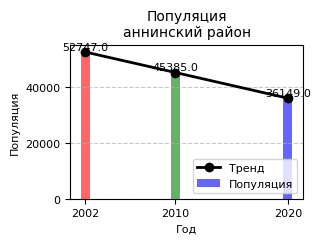
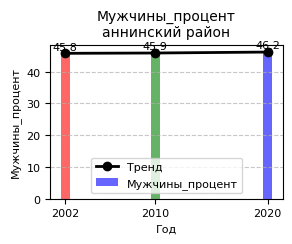
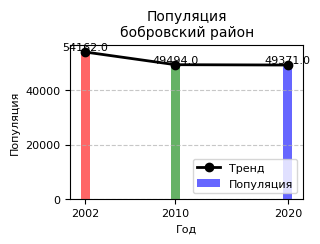
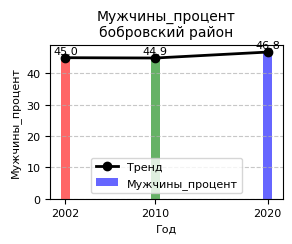
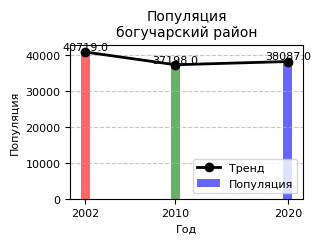
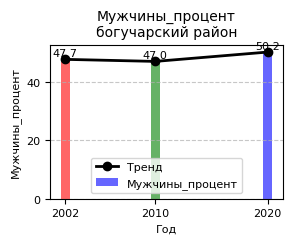
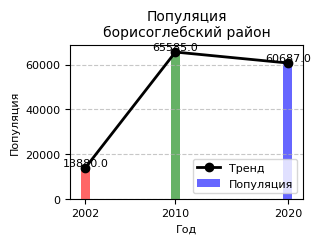
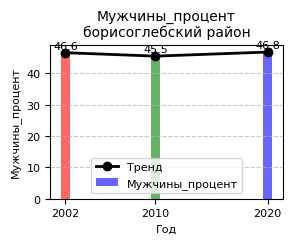
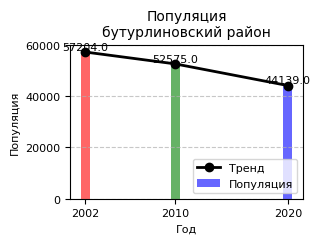
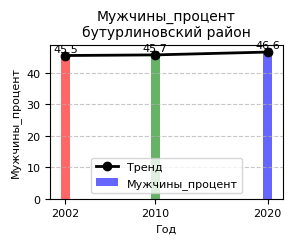
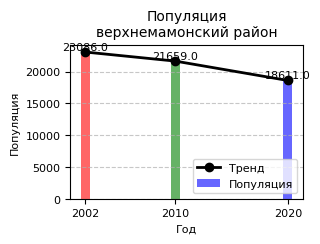
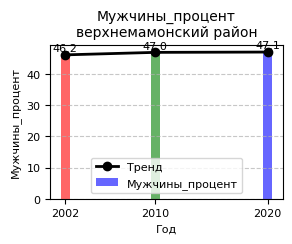
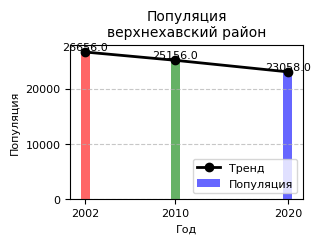
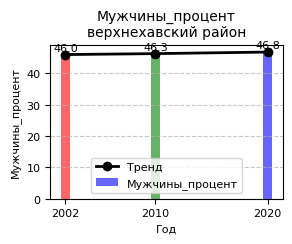
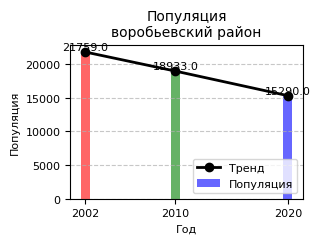
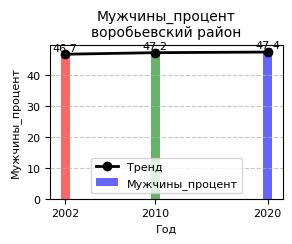
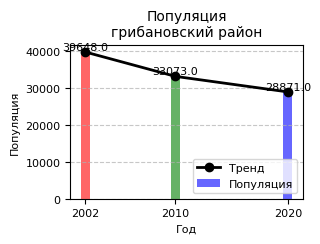
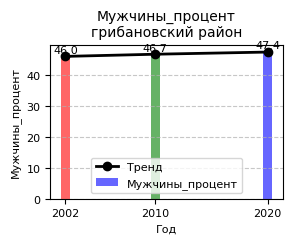
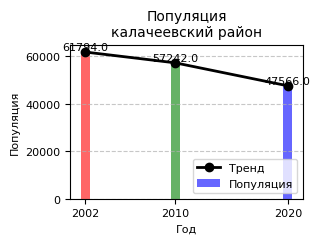
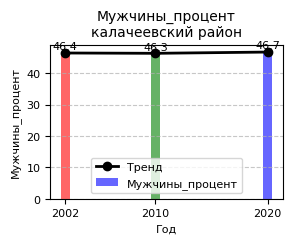
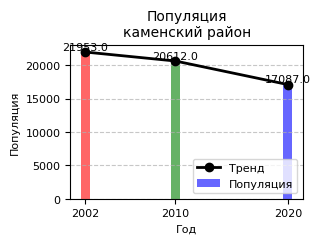
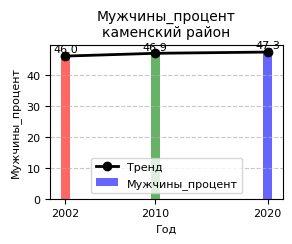
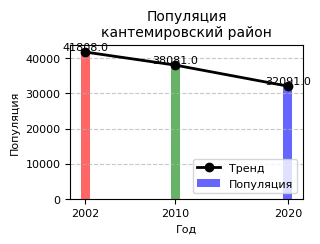
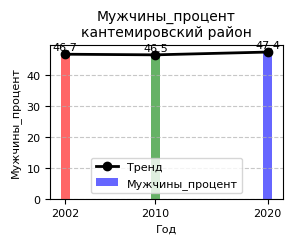
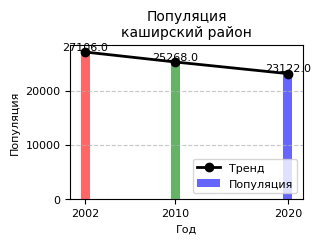
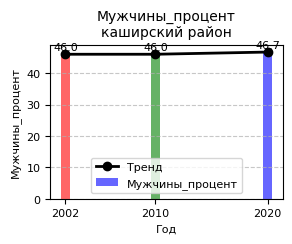
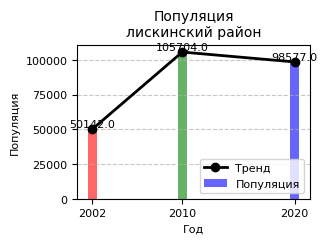
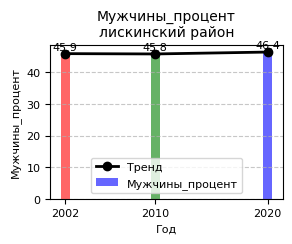
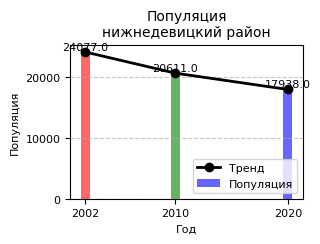
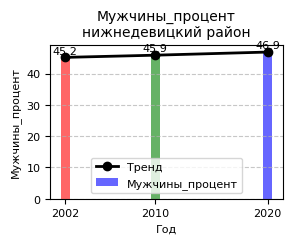
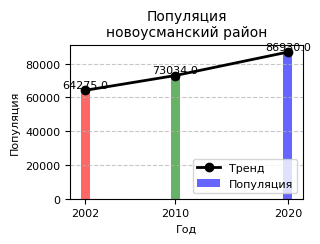
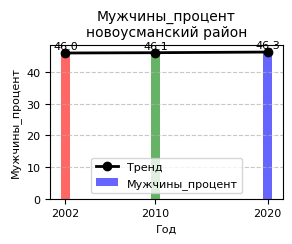
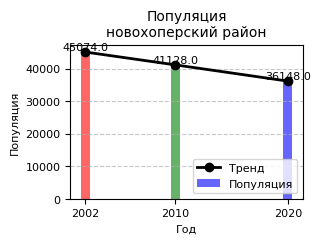
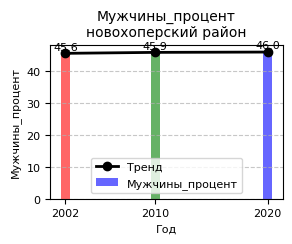
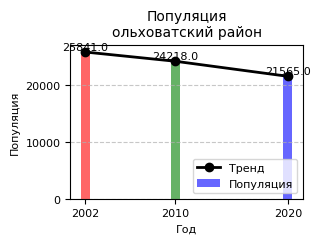
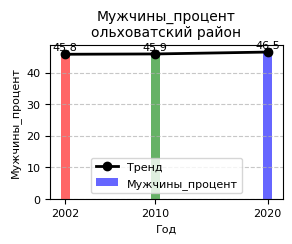
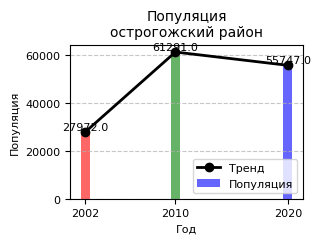
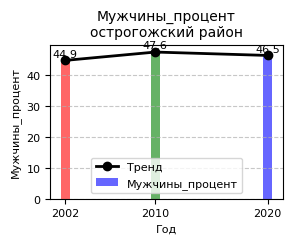
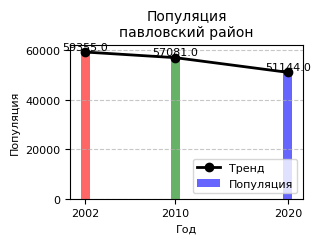
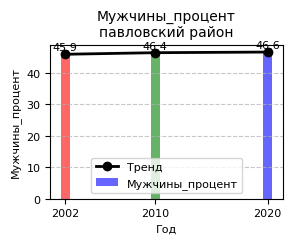
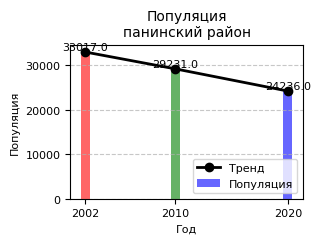
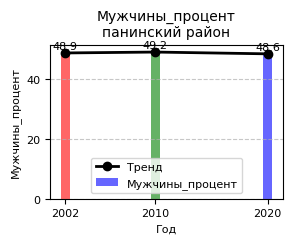
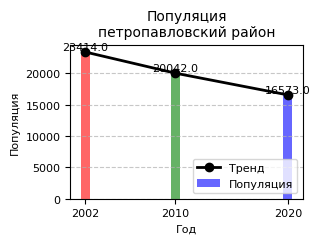
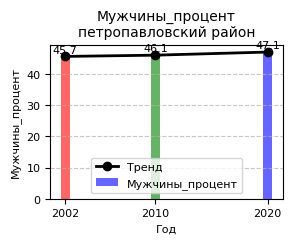
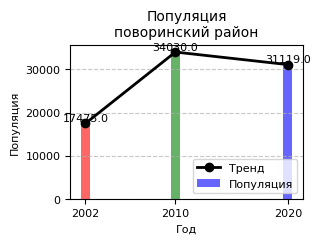
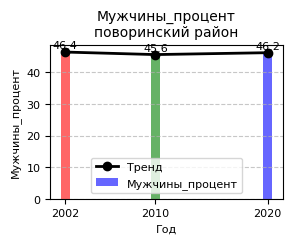
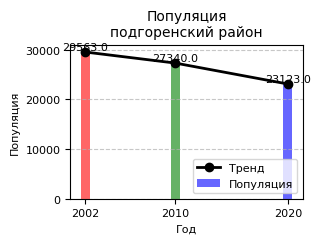
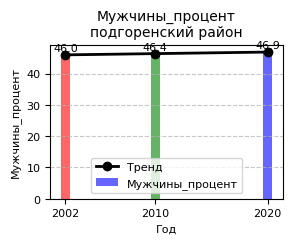
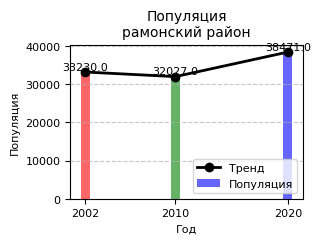
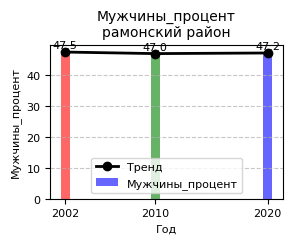
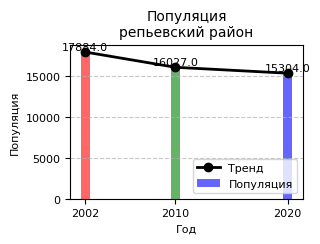
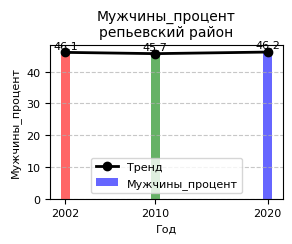
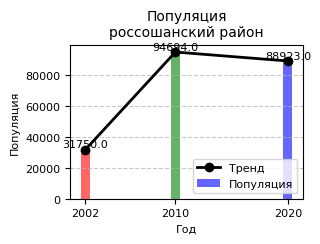
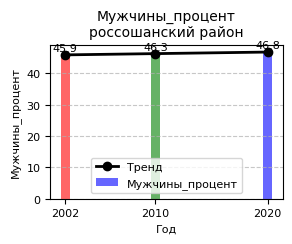
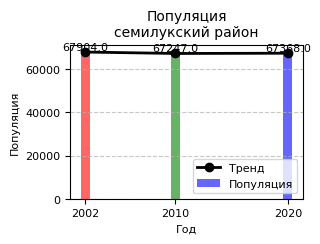
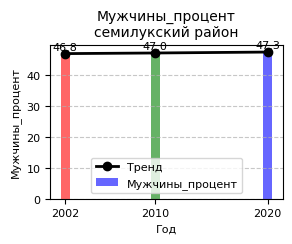
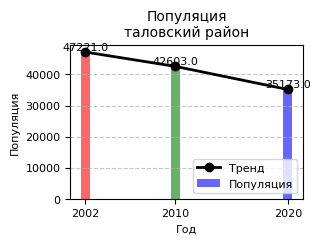
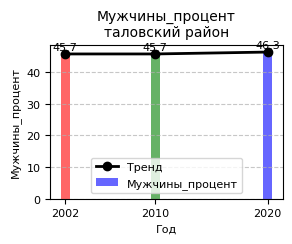
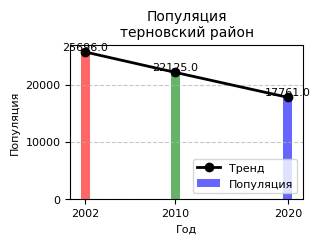
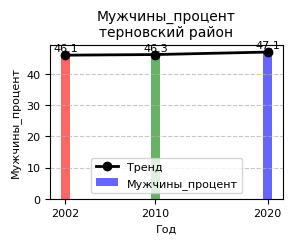
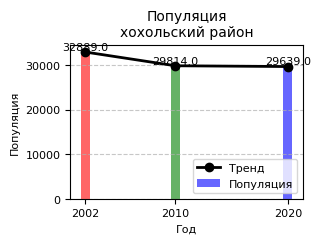
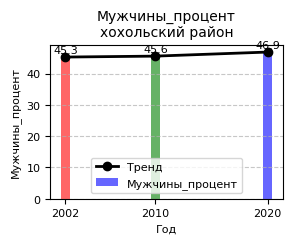
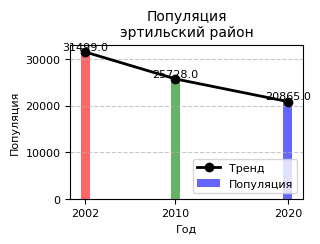
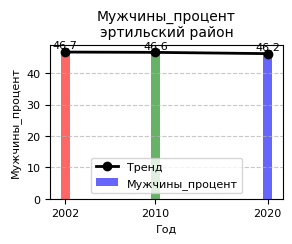
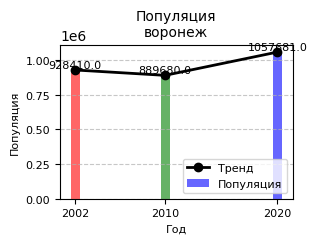
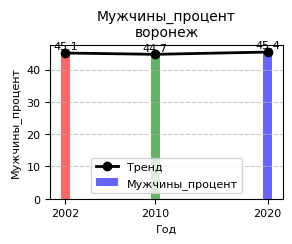
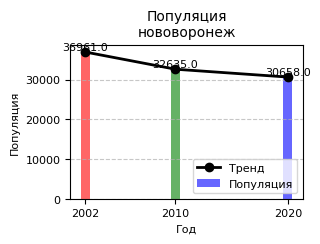
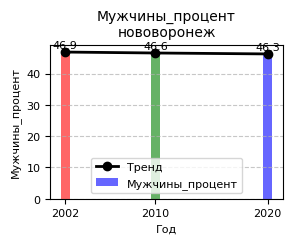
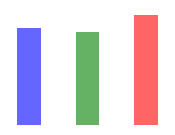
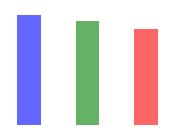
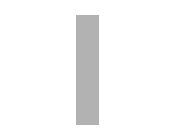
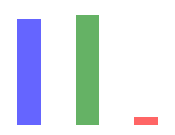
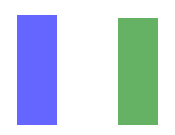
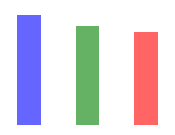
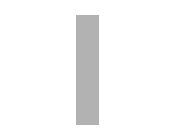
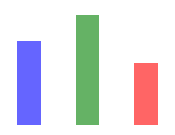
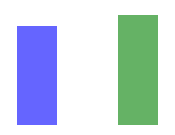
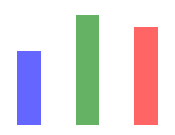
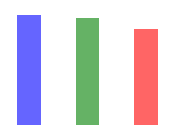
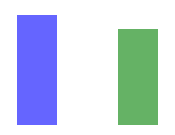
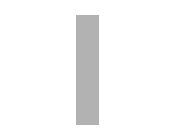
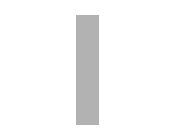
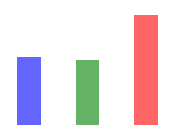
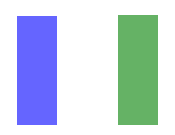
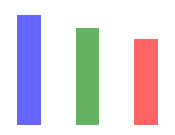
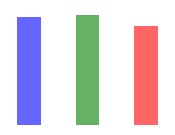
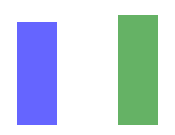
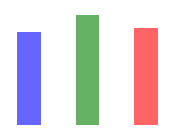
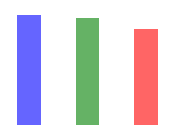
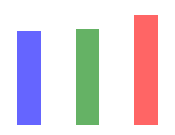
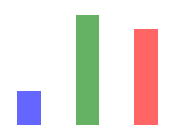
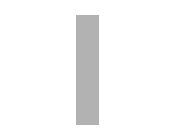
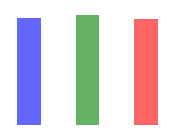
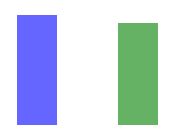
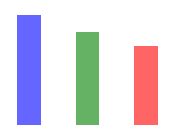
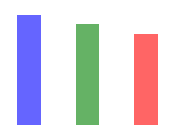
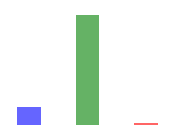
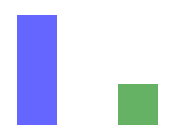
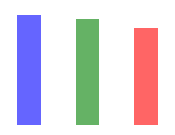
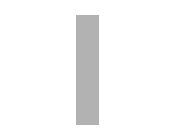
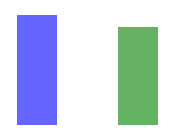
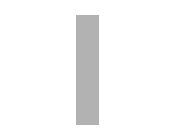
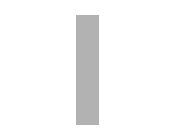
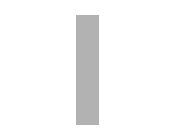
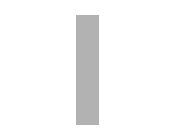
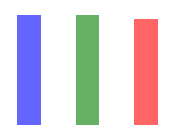
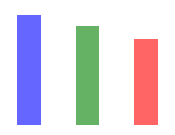
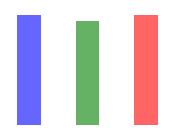
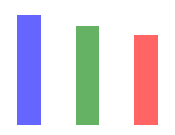
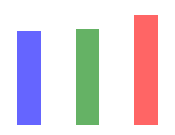
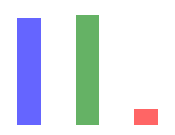
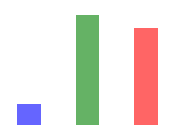
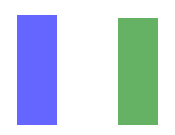
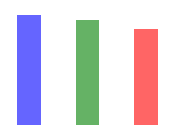
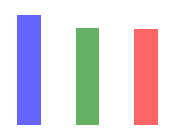
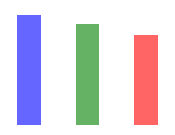
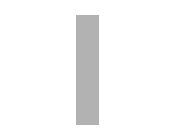
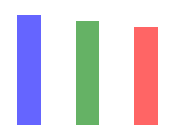
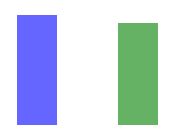
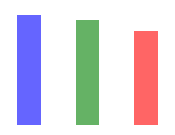
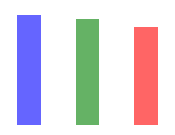
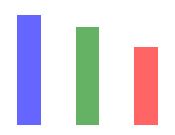
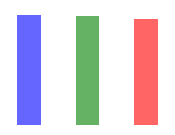
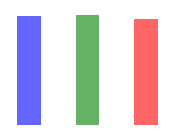
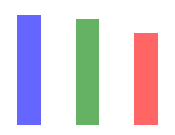
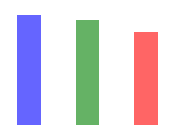
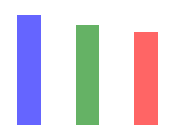
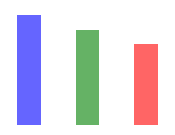
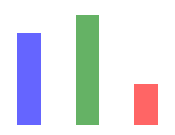
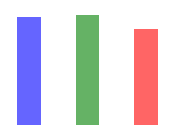
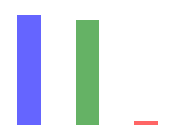
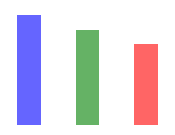
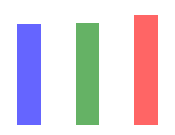
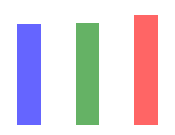
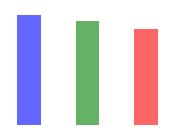
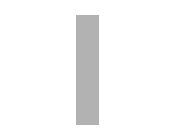
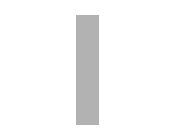
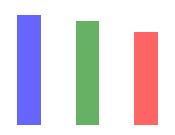
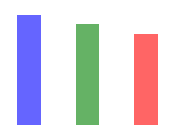
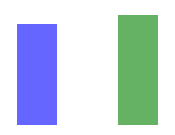
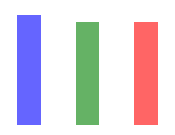
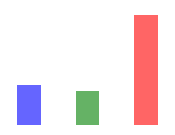
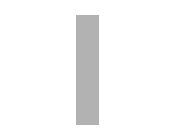
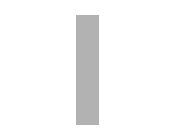
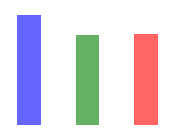
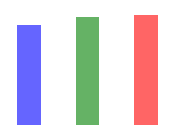
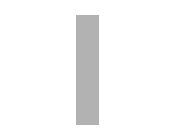
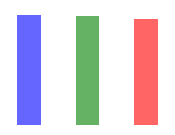
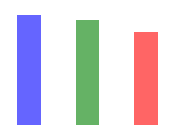
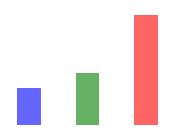
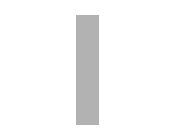
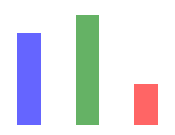
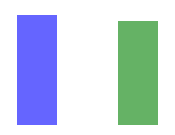
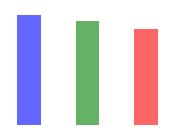
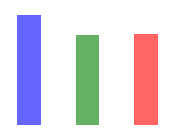
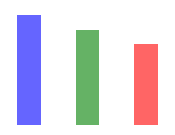
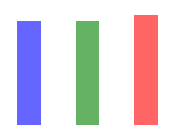
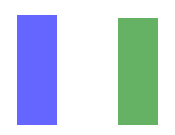
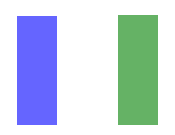
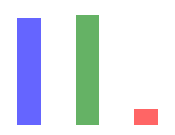
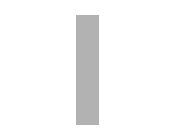
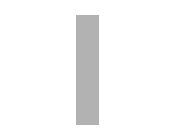
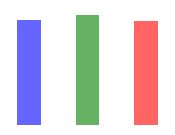
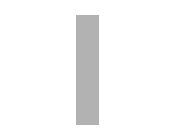
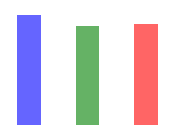
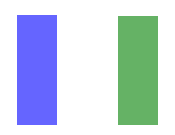
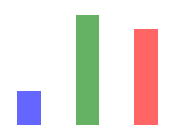
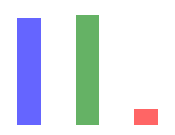
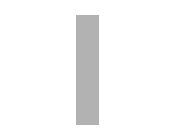
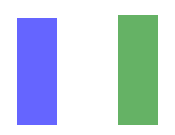
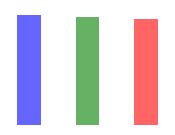
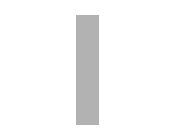
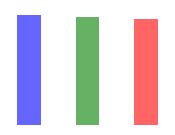
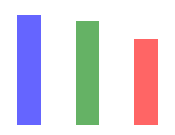
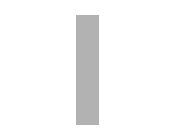
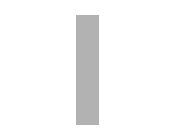
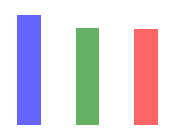
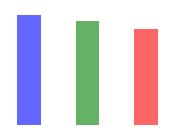
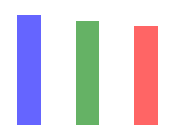
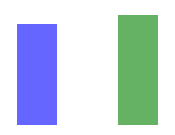
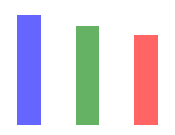
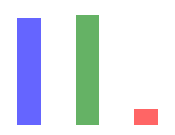
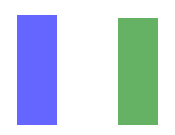
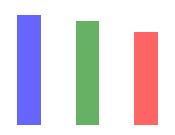
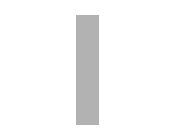
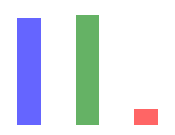
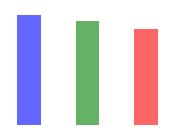
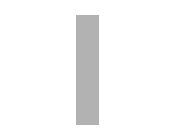
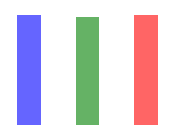
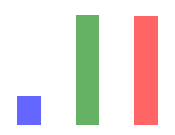
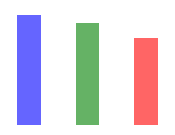
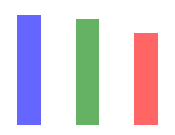
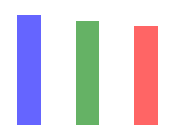
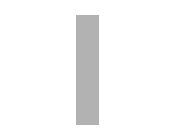
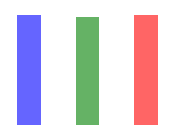
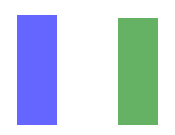
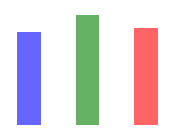
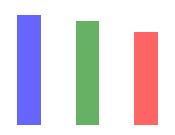
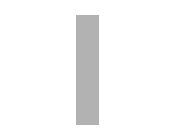
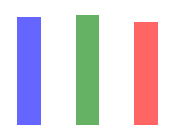
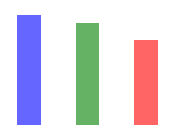
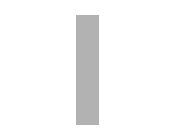
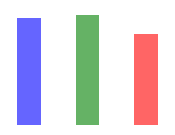
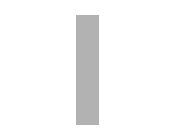
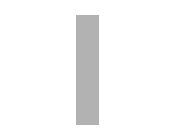
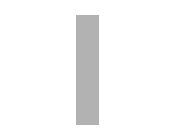
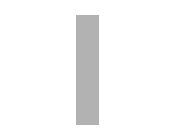
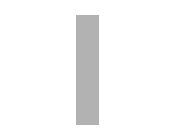
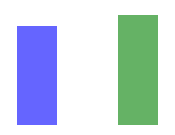
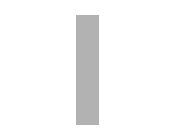
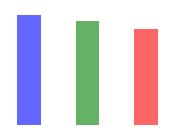
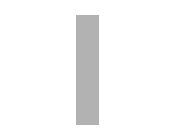
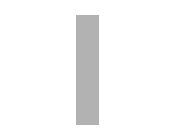
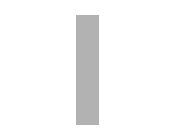
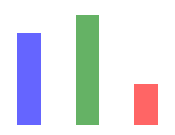
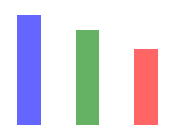
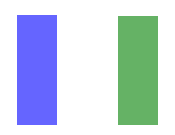
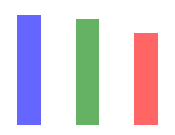
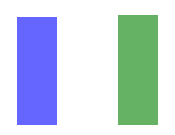
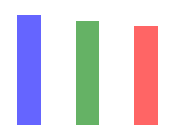
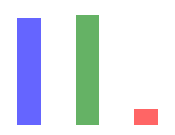
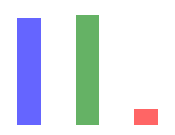
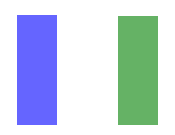
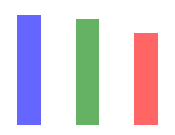
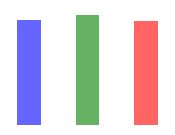
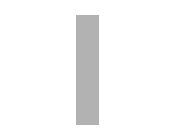
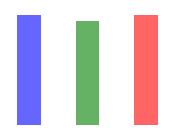
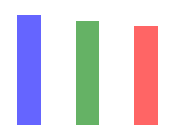
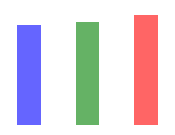
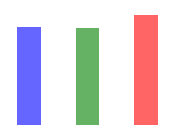
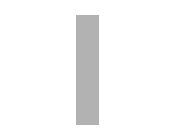
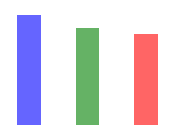
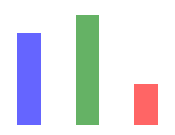
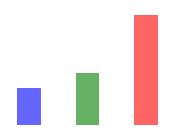
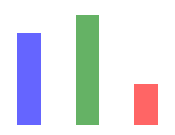
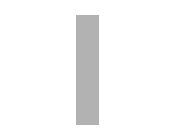
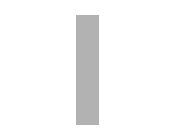
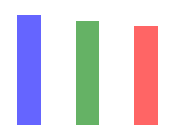
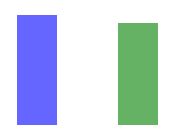
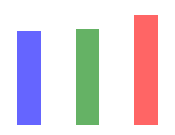
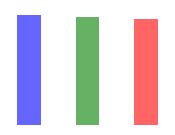
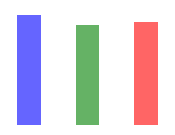
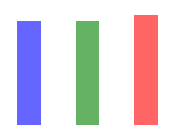
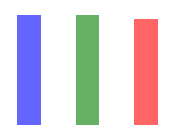
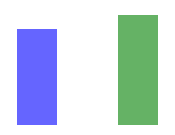
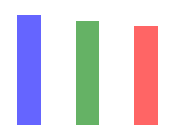
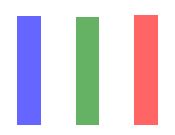
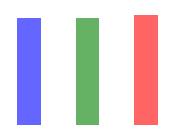
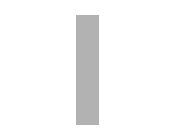
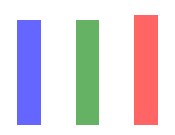
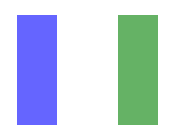
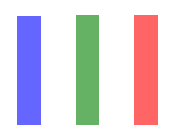
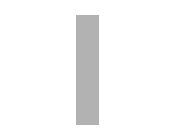
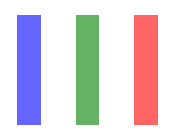
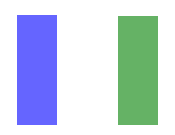
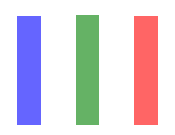
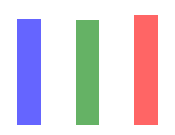
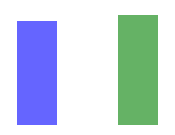
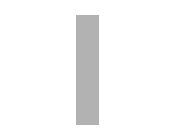
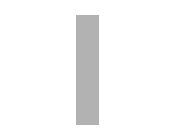
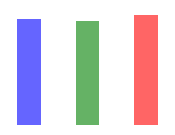
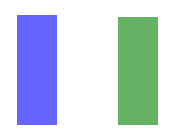
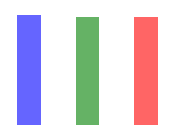
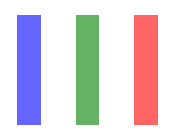
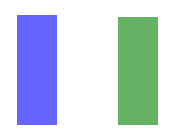
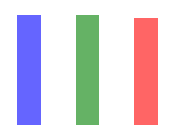
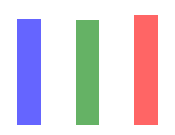
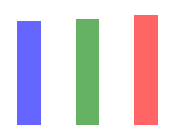
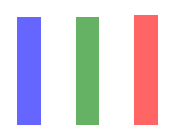
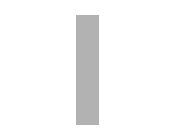
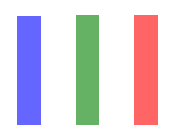
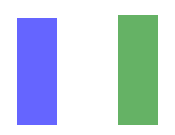
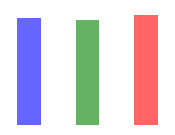
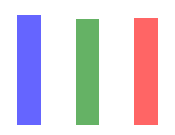
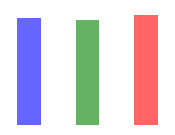
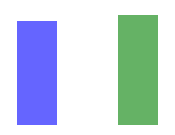
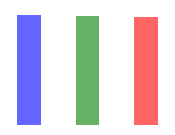
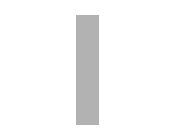
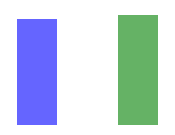
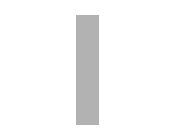
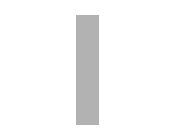
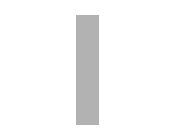
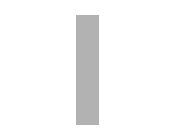
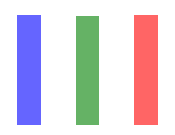
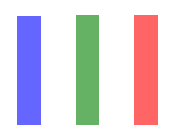
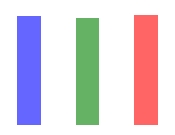
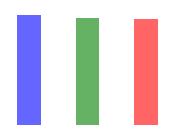
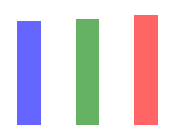
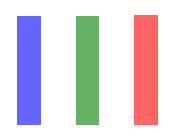
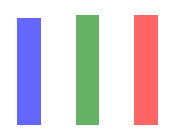
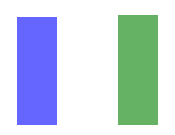
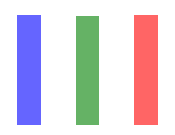
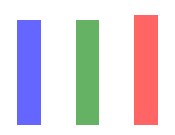
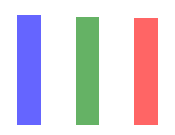
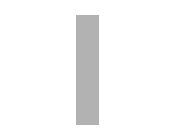
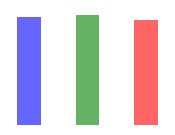
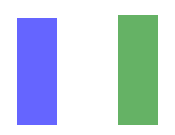
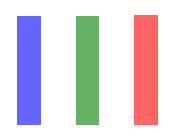
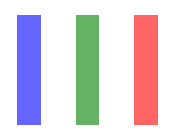
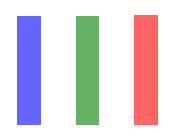
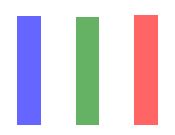
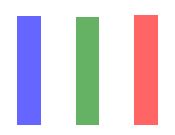
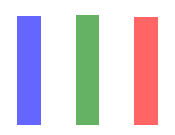
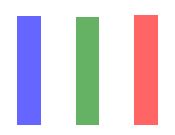
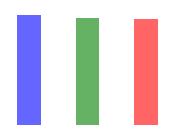
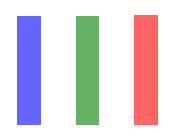
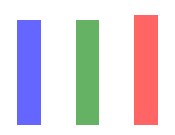
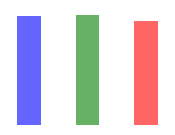
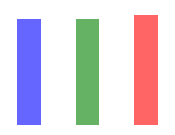
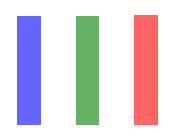
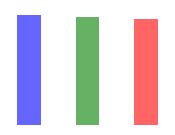
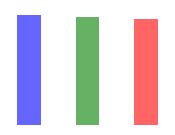
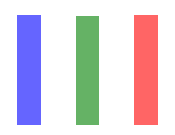
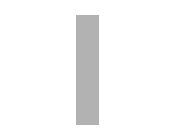
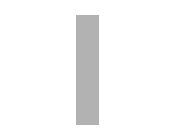
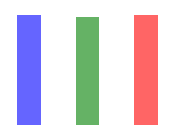
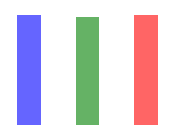
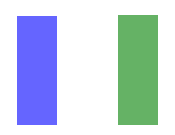
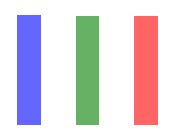
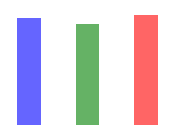
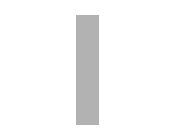
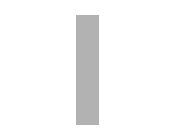
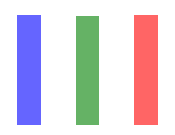
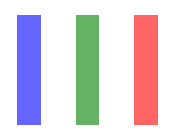
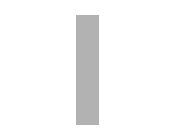
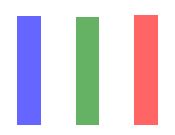
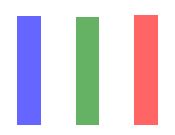
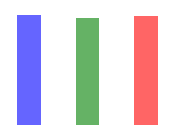
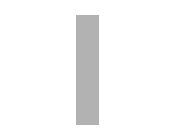
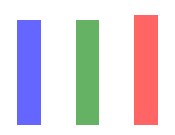
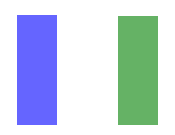
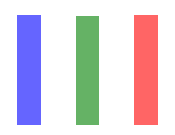
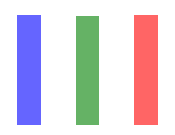
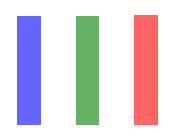
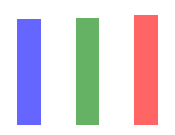
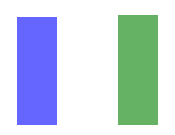
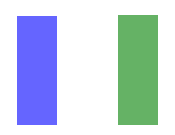
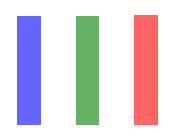
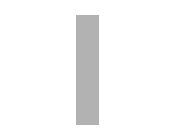
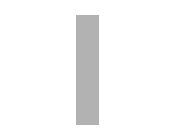
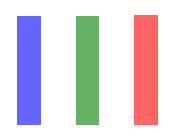
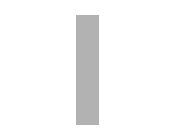
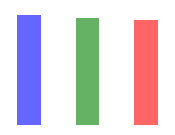
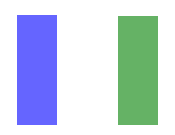
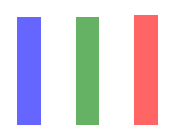
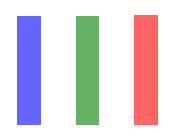
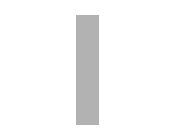
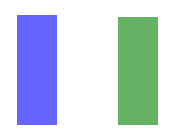
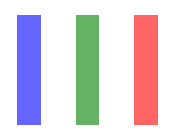
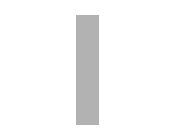
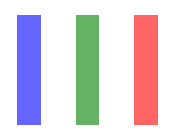
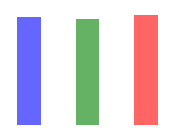
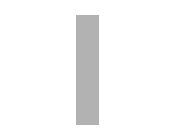
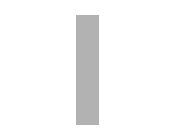
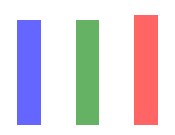
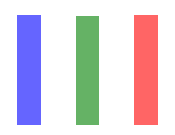
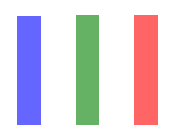
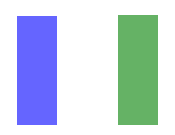
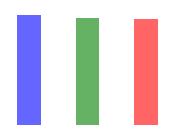
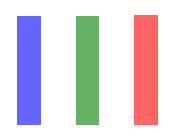
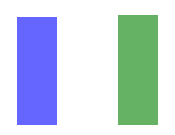
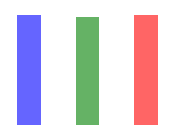
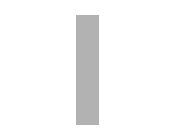
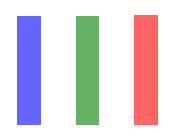
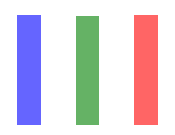
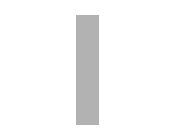
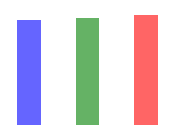
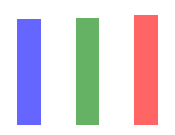
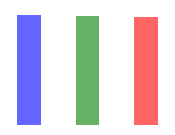
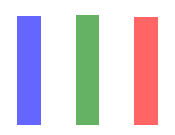
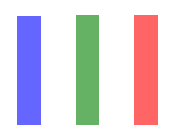
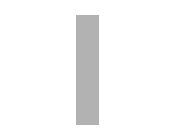
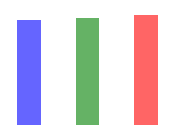
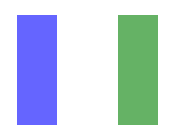
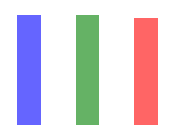
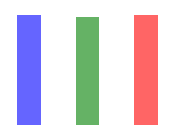
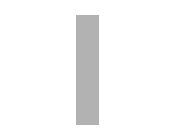
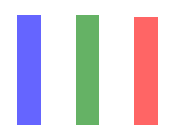
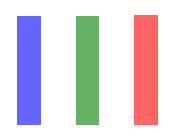
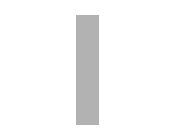
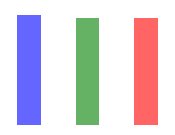
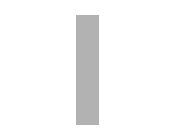
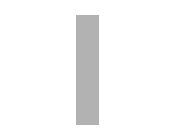
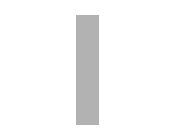
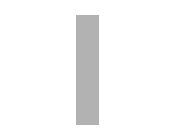
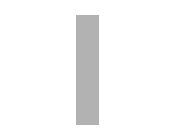
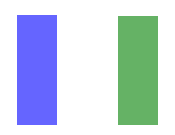
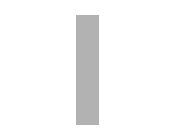
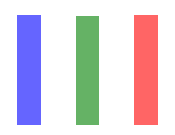
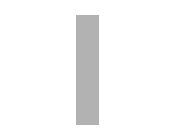
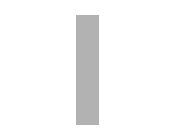
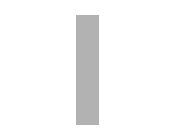
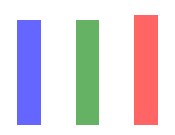
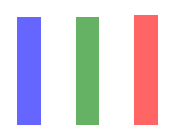
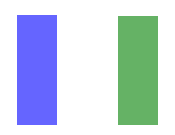
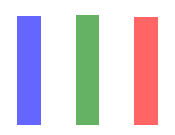
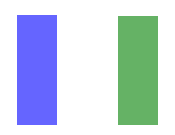
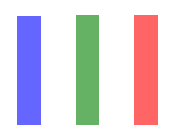
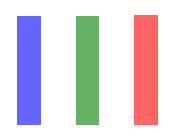
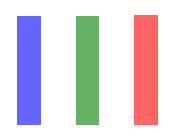
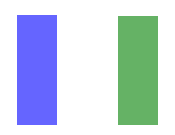
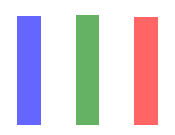
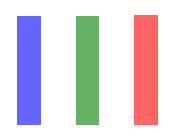
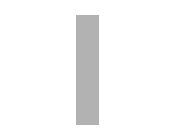
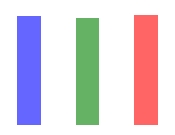
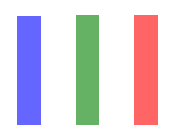
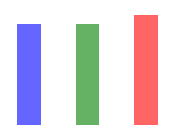
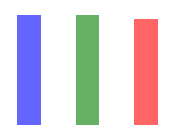
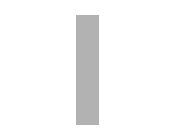
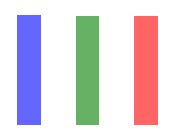
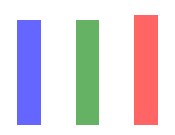
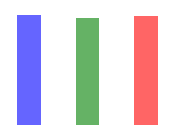
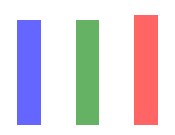
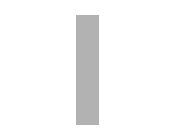
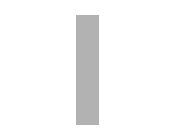
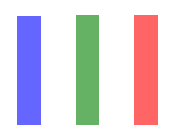
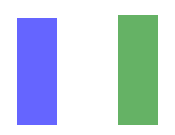
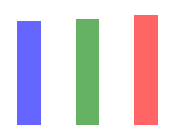
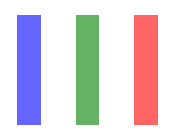
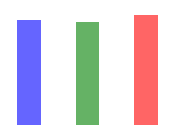
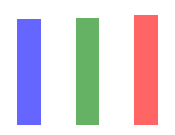
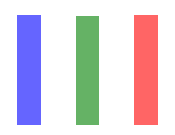
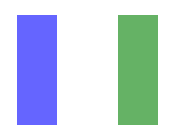
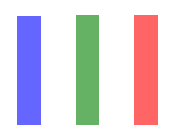
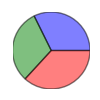
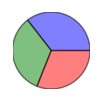
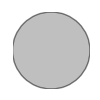
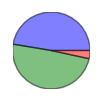
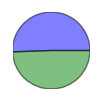
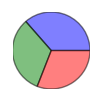
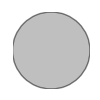
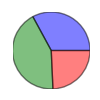
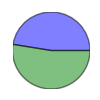
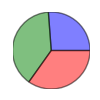
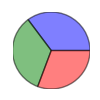
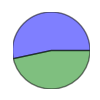
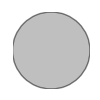
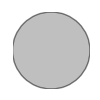
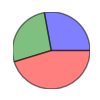
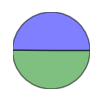
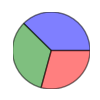
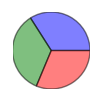
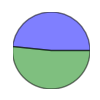
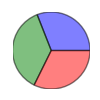
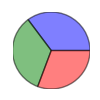
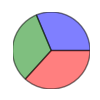
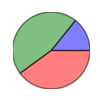
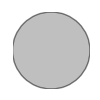
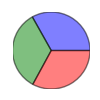
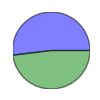
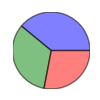
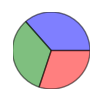
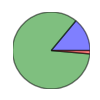
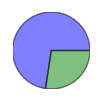
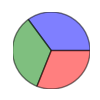
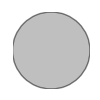
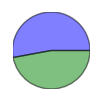
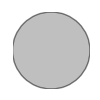
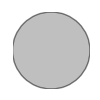
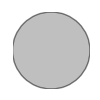
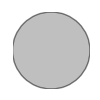
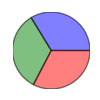
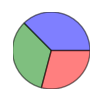
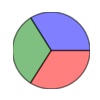
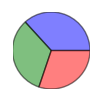
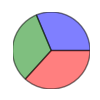
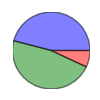
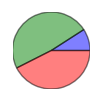
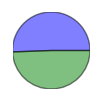
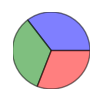
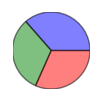
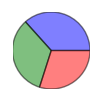
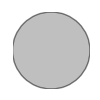
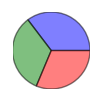
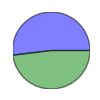
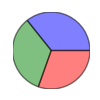
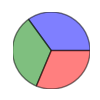
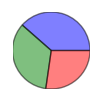
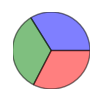
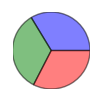
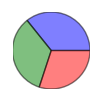
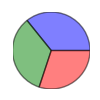
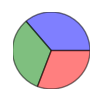
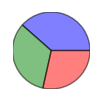
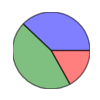
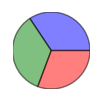
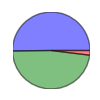
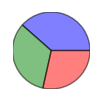
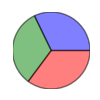
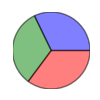
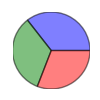
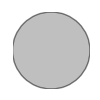
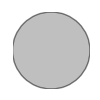
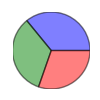
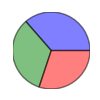
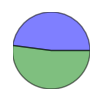
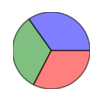
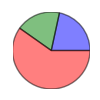
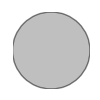
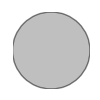
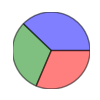
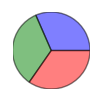
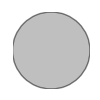
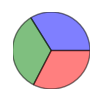
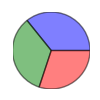
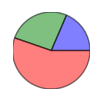
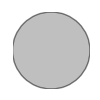
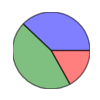
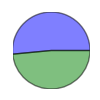
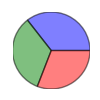
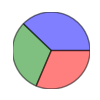
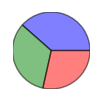
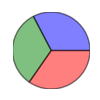
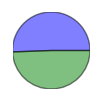
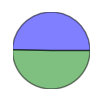
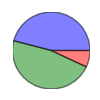
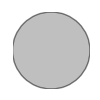
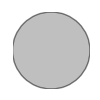
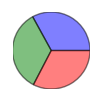
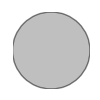
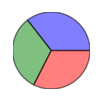
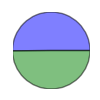
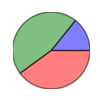
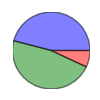
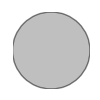
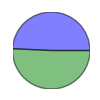
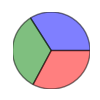
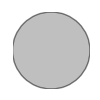
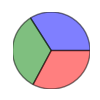
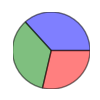
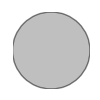
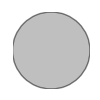
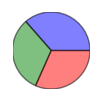
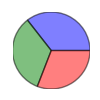
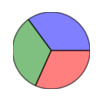
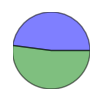
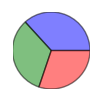
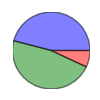
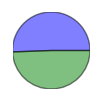
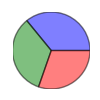
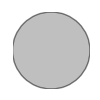
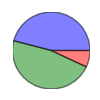
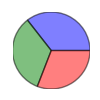
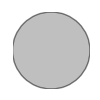
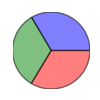
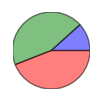
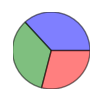
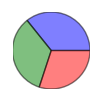
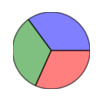
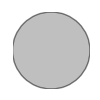
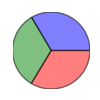
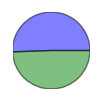
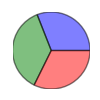
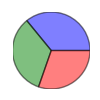
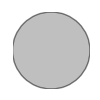
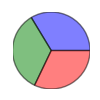
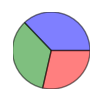
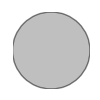
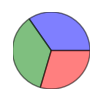
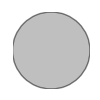
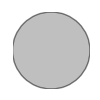
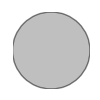
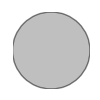
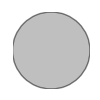
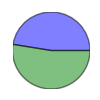
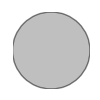
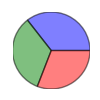
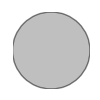
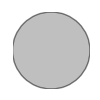
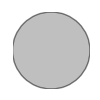
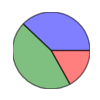
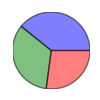
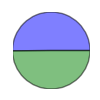
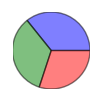
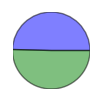
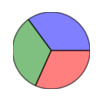
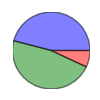
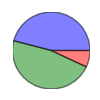
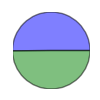
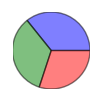
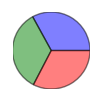
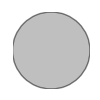
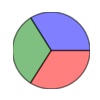
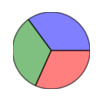
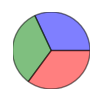
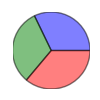
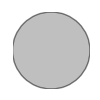
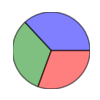
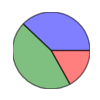
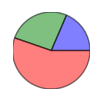
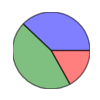
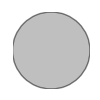
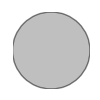
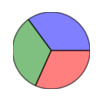
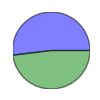
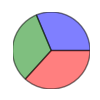
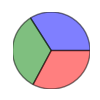
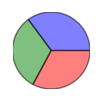
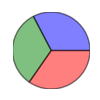
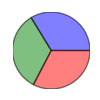
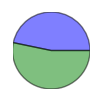
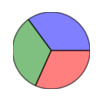
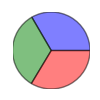
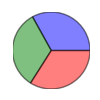
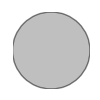
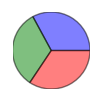
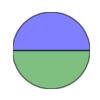
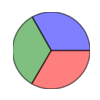
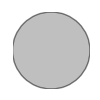
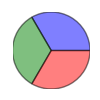
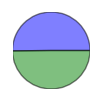
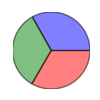
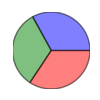
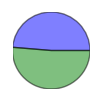
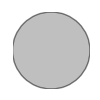
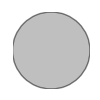
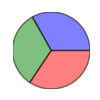
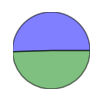
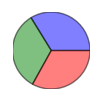
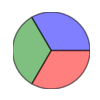
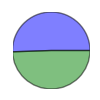
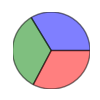
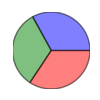
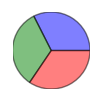
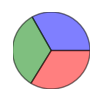
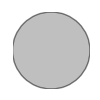
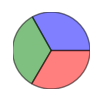
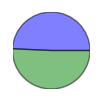
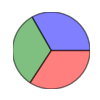
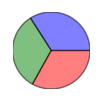
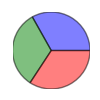
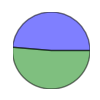
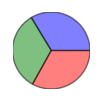
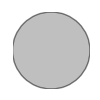
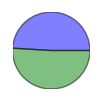
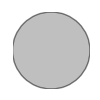
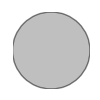
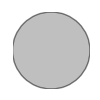
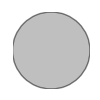
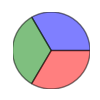
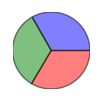
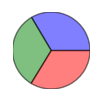
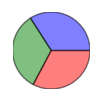
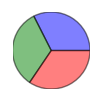
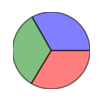
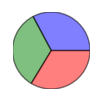
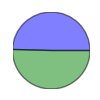
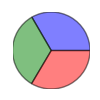
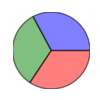
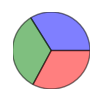
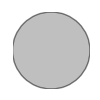
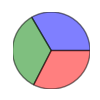
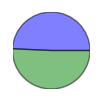
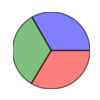
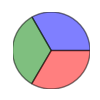
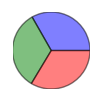
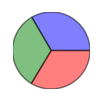
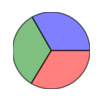
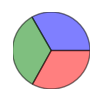
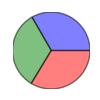
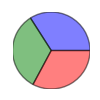
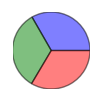
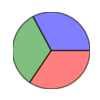
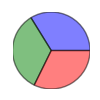
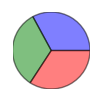
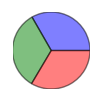
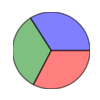
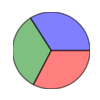
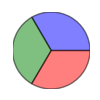
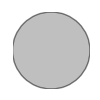
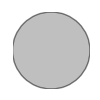
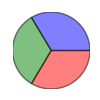
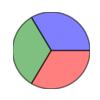
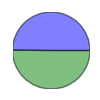
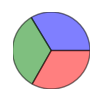
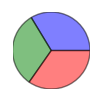
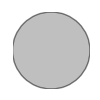
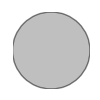
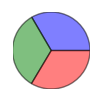
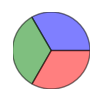
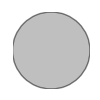
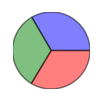
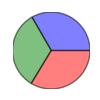
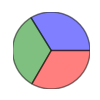
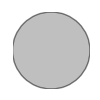
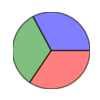
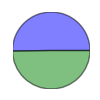
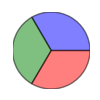
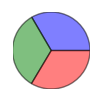
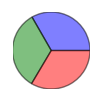
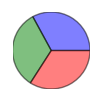
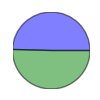
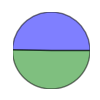
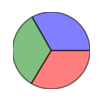
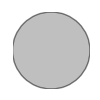
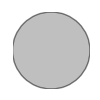
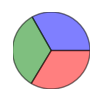
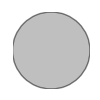
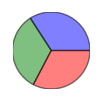
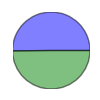
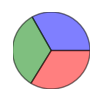
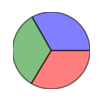
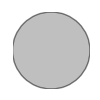
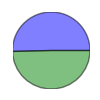
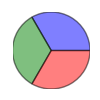
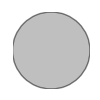
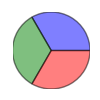
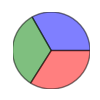
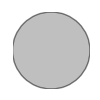
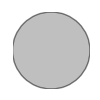
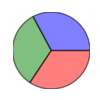
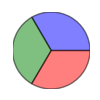
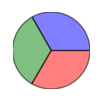
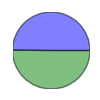
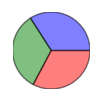
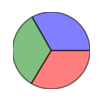
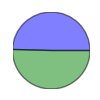
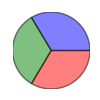
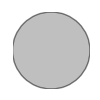
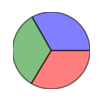
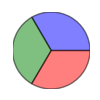
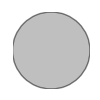
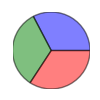
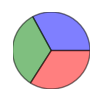
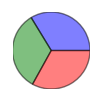
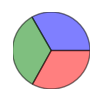
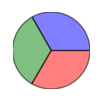
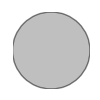
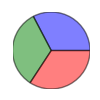
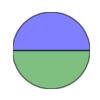
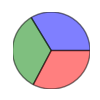
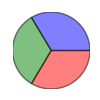
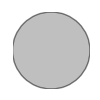
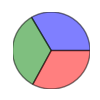
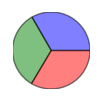
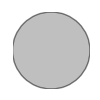
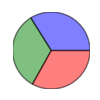
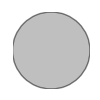
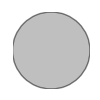
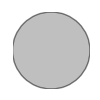
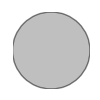
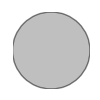
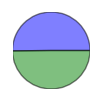
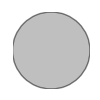
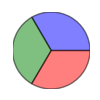
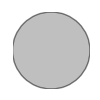
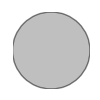
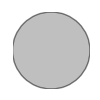
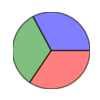
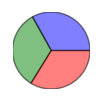
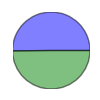
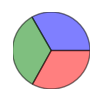
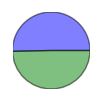
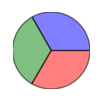
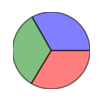
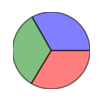
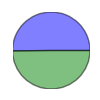
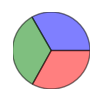
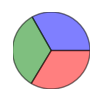
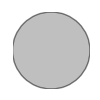
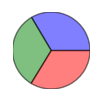
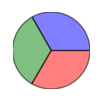
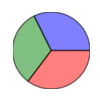
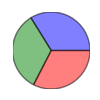
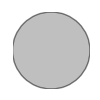
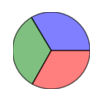
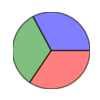
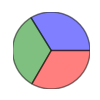
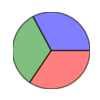
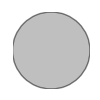
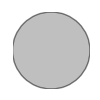
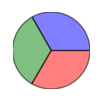
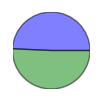
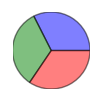
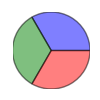
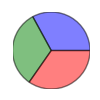
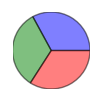
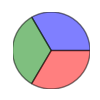
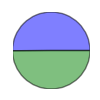
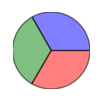

In [ ]:
# Слой для районов
district_layer = folium.FeatureGroup(name="Районы")
folium.GeoJson(
    geojson_data,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['district', 'population'], aliases=['Район:', 'Население:'], localize=True),
    popup=folium.GeoJsonPopup(fields=['popup_html'], aliases=[None], localize=True, labels=False, parse_html=True, max_width=800),
    highlight_function=lambda x: {'weight': 3, 'color': 'black'}
).add_to(district_layer)
district_layer.add_to(m)

# Словарь для русских названий типов маркеров
marker_type_russian_names = {
    'standard': "Стандартные маркеры",
    'bar': "Столбцы",
    'pie': "Круговая диаграмма",
    'circle': "Размерный круг"
}

# Создание слоёв для комбинаций "тип маркера + тип данных" с русскими названиями
marker_data_layers = {}
for marker_type in ['standard', 'bar', 'pie', 'circle']:
    marker_data_layers[marker_type] = {}
    for data_type in available_data:
        layer_name = f"{marker_type_russian_names[marker_type]} - {get_russian_name(data_type)}"
        marker_data_layers[marker_type][data_type] = folium.FeatureGroup(name=layer_name, show=False)

# Добавляем все слои на карту
for marker_type in ['standard', 'bar', 'pie', 'circle']:
    for data_type in available_data:
        marker_data_layers[marker_type][data_type].add_to(m)

# Получение и обработка данных о населённых пунктах
settlements_data = fetch_settlements_from_overpass()
if settlements_data:
    print("Данные о населённых пунктах с OpenStreetMap успешно получены")
    settlements = process_settlements_data(settlements_data, combined_data_df)
    print("Добавление населённых пунктов на карту...")

    # Добавляем маркеры для каждой комбинации "тип маркера + тип данных"
    for marker_type in ['standard', 'bar', 'pie', 'circle']:
        for data_type in available_data:
            if marker_type == 'standard':
                add_standard_markers(settlements, marker_data_layers[marker_type][data_type], data_type)
            elif marker_type == 'bar':
                add_bar_chart_markers(settlements, marker_data_layers[marker_type][data_type], data_type)
            elif marker_type == 'pie':
                add_pie_chart_markers(settlements, marker_data_layers[marker_type][data_type], data_type)
            elif marker_type == 'circle':
                add_circle_markers(settlements, marker_data_layers[marker_type][data_type], data_type)

    # Группируем слои для GroupedLayerControl с использованием русских названий
    marker_groups = {
        'Типы маркеров': [
            marker_data_layers[marker_type][data_type]
            for marker_type in ['standard', 'bar', 'pie', 'circle']
            for data_type in available_data
        ]
    }

    folium.LayerControl().add_to(m)
    
    GroupedLayerControl(
        groups=marker_groups,
        exclusive_groups=True,  # Разрешаем выбор только одного типа маркера и данных
        collapsed=True,
    ).add_to(m)

    print("Данные о населённых пунктах успешно добавлены на карту")
else:
    print("Не удалось получить данные о населённых пунктах.")

# Сохранение карты
output_map_path = 'map.html'
print(f"Сохранение карты...")
m.save(output_map_path)
print(f"Карта успешно сохранена в файл: {output_map_path}")
display(m)

In [ ]:
# Функция для загрузки файла на FTP-сервер
def upload_to_ftp(file_path, ftp_host, ftp_user, ftp_pass, ftp_dir="/"):
    import ftplib
    try:
        # Устанавливаем соединение с FTP-сервером
        with ftplib.FTP(ftp_host) as ftp:
            ftp.login(user=ftp_user, passwd=ftp_pass)
            print(f"Успешно подключено к FTP-серверу: {ftp_host}")

            # Переходим в указанную директорию (по умолчанию корень)
            ftp.cwd(ftp_dir)

            # Открываем файл для загрузки
            with open(file_path, 'rb') as file:
                file_name = os.path.basename(file_path)
                ftp.storbinary(f'STOR {file_name}', file)
                print(f"Файл {file_name} успешно загружен на FTP-сервер в директорию {ftp_dir}")

    except ftplib.all_errors as e:
        print(f"Ошибка при загрузке на FTP: {e}")